# Exploring Empirical moment generating functions

In [198]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf

In [199]:
from scipy.stats import bootstrap

## Statistics of empirical MGF

In [15]:
N = 100
data = np.random.randn(N)

outs = []
ts = np.linspace(-2, 2)
for t in ts:
    outs.append( np.exp(t*data).mean())

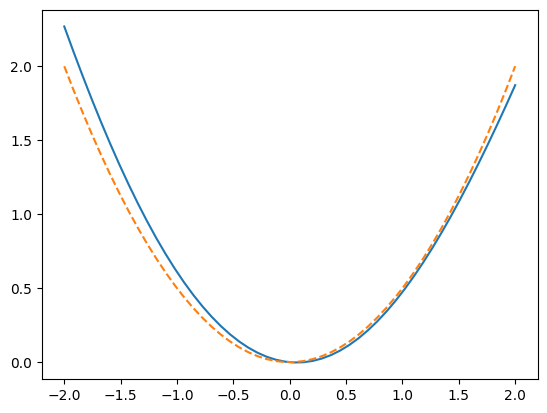

In [17]:
plt.plot(ts, np.log(outs))
plt.plot(ts, ts**2 / 2, '--')

Ok, nice. Even this small data set is sufficient to achieve a pretty good approximation. That's good if our input data is limited.

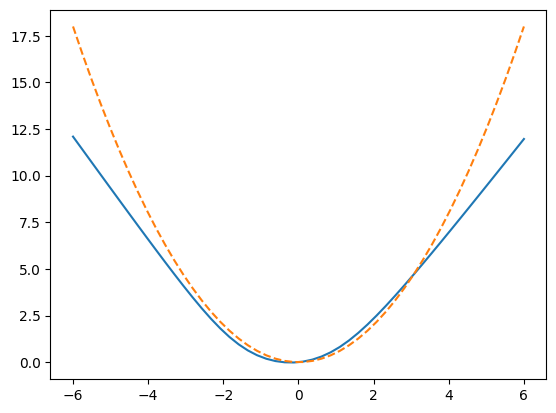

In [19]:
N = 100
data = np.random.randn(N)

outs = []
ts = np.linspace(-6, 6)
for t in ts:
    outs.append( np.exp(t*data).mean())

plt.plot(ts, np.log(outs))
plt.plot(ts, ts**2 / 2, '--')

Breaks down at larger values of t.

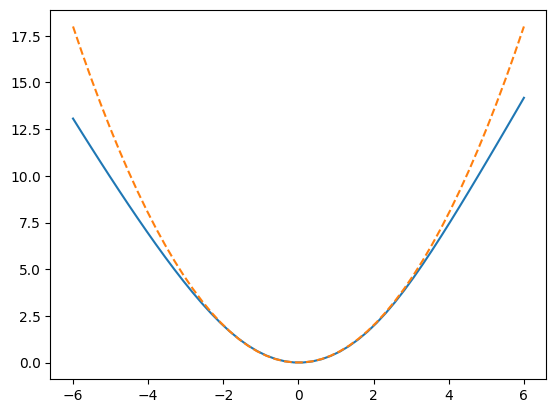

In [26]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-6, 6)

plt.plot(ts, make_CGF(ts, data))
plt.plot(ts, ts**2 / 2, '--')

It does have trouble recovering more extreme values, even if we massively scale up the number of data points. I suspect that this is because we almost never sample such extreme values.

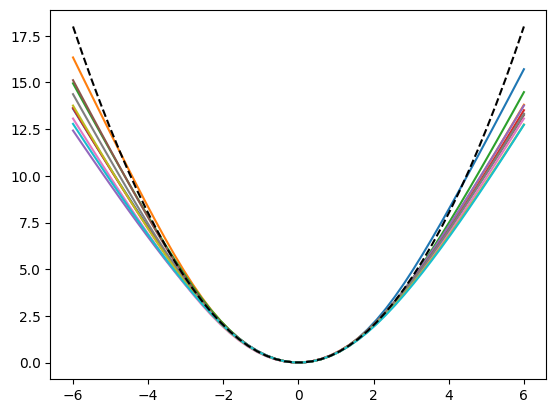

In [28]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-6, 6)

for i in range(10):
    data = np.random.randn(N)
    plt.plot(ts, make_CGF(ts, data))
    
plt.plot(ts, ts**2 / 2, '--k')

The results are, without doubt, negatively biased. This is not surprising given that the log is a concave function, but still a bit irritating.

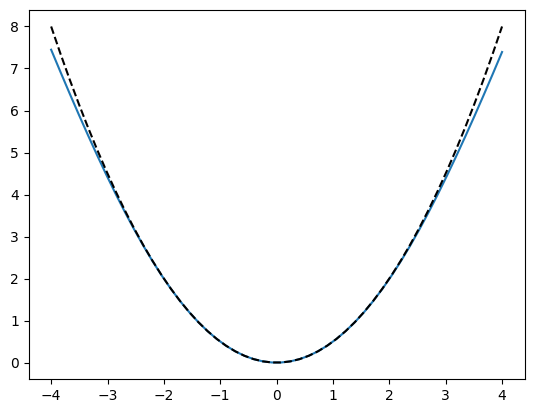

In [35]:
N = 5000
data = np.random.randn(N)

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-4, 4)
tot = np.zeros(50)

for i in range(500):
    data = np.random.randn(N)
    #plt.plot(ts, make_CGF(ts, data))
    tot +=  make_CGF(ts, data)

plt.plot(ts, tot / 500)
plt.plot(ts, ts**2 / 2, '--k')

The negative bias again, only shows up in the tails, which I think is a result of their sparse sampling

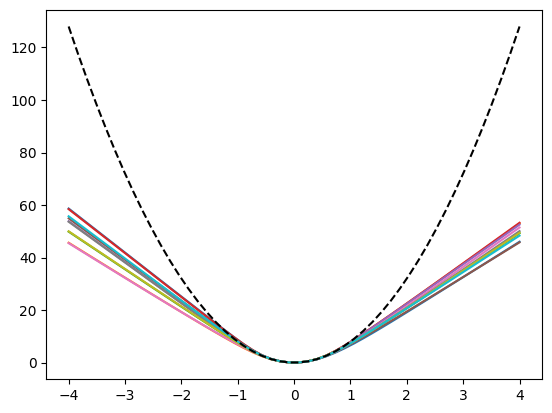

In [124]:
N = 5000

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-4, 4)

for i in range(10):
    data = 4*np.random.randn(N)
    plt.plot(ts, make_CGF(ts, data))

plt.plot(ts, 4**2*ts**2 / 2, '--k')

Interestingly, increasing the variance of the distribution actually makes the fit worse at large distances.

This is more worrying. It is also quite interesting to me that the bias increases so much relative to the variance

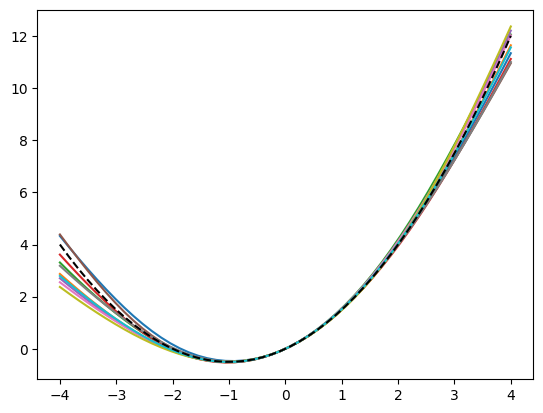

In [51]:
N = 5000

def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

ts = np.linspace(-4, 4)
tot = np.zeros(50)

for i in range(10):
    data = np.random.randn(N) + 1
    plt.plot(ts, make_CGF(ts, data))
    tot +=  make_CGF(ts, data)

plt.plot(ts, ts + ts**2 / 2, '--k')

The mean doesn't impact the fits. 

### Direct MGF fitting: does it remove the bias?

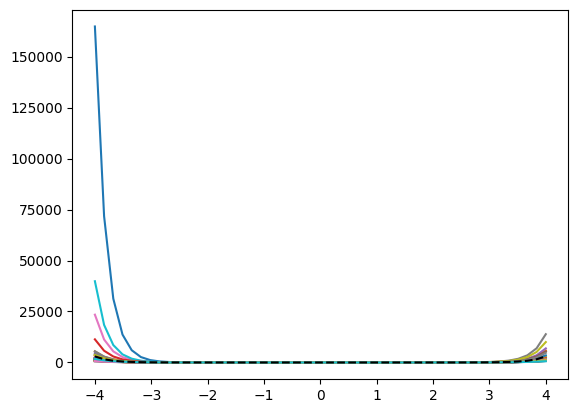

In [61]:
N = 5000

def make_MGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return outs

ts = np.linspace(-4, 4)

for i in range(50):
    data = np.random.randn(N)
    plt.plot(ts, make_MGF(ts, data))

plt.plot(ts, np.exp(ts**2 / 2), '--k')

Hard to tell if the same problem affects the MGF (without the log)

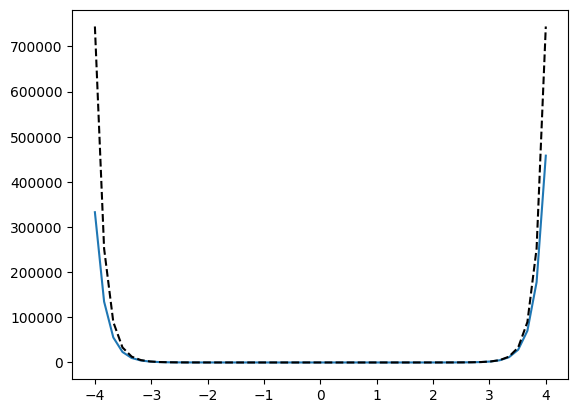

In [81]:
N = 5000

def make_MGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return outs

ts = np.linspace(-4, 4)

tot = np.zeros(50)
for i in range(500):
    data = 1.3*np.random.randn(N)
    tot += make_MGF(ts, data)

plt.plot(ts, tot / 500)
plt.plot(ts, np.exp((1.3**2)*ts**2 / 2), '--k')

Yeah, it's hard to tell, but it seems to me that the estimate is still undershooting the tails. This suggests that the bias is not caused by the log alone.

### Previous work by Dunfield et al. uses a batch sum in the exponent

Trying out that approach

Text(0.5, 1.0, 'Batch sum in exponent')

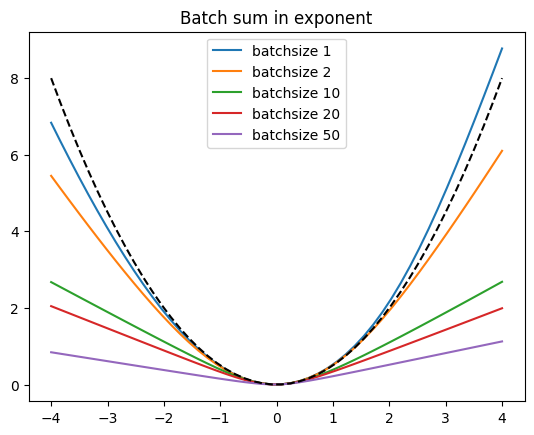

In [226]:
N = 5000

data = np.random.randn(N)

ts = np.linspace(-4, 4)

for b in [1, 2, 10, 20, 50]:
    blocks = np.split(data, N//b)
    block_sums = np.fromiter(map(np.sum, blocks), dtype=float)

    outs = []    
    for t in ts:
        outs.append( 1/b * np.log(np.exp(t*block_sums).mean()) )

    plt.plot(ts, outs, label=f'batchsize {b}')

plt.plot(ts, ts**2 / 2, '--k')
plt.legend()
plt.title('Batch sum in exponent')

Text(0.5, 1.0, 'Batch sum in exponent: double variance')

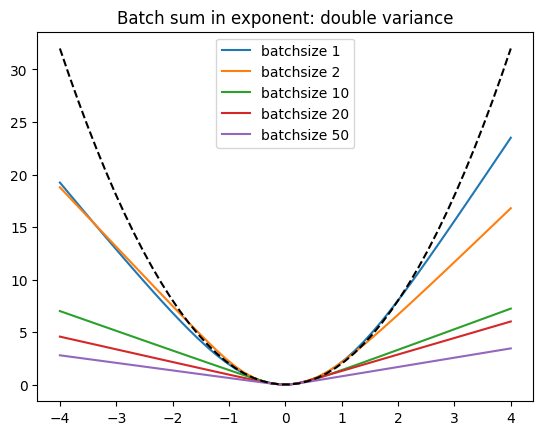

In [227]:
N = 5000

data = 2*np.random.randn(N)

ts = np.linspace(-4, 4)

for b in [1, 2, 10, 20, 50]:
    blocks = np.split(data, N//b)
    block_sums = np.fromiter(map(np.sum, blocks), dtype=float)

    outs = []    
    for t in ts:
        outs.append( 1./b * np.log(np.exp(t*block_sums).mean()) )

    plt.plot(ts, outs, label=f'batchsize {b}')

plt.plot(ts, 4*ts**2 / 2, '--k')
plt.legend()
plt.title('Batch sum in exponent: double variance')

Odd. This doesn't seem to improve the fit. It makes it worse.

In [139]:
np.exp(t*block_sums).mean()

9.644221993236841e+62

In [142]:
(b / N) *np.exp(t*block_sums).sum()

9.644221993236841e+62

One obvious problem is the sheer size of these sums: this will cause round off error itself.

In [180]:
np.log((b / N) *np.exp(t*block_sums).sum())

14.123517917093576

#### Thinking through the isses that we see here

1. It is clear that larger variance in the input variables results in larger bias in the output. Why is this?

We are getting functional forms, so there are a couple of tricks that we can play:
- standardizing
- averageing
followed by a varable transformation to undo them.

#### In the paper, they say:
- increasing the block size to reduce bias, and
- decreasing the block size to reduce variance.

By that metric, we have a variance problem.


### Why is there any bias at all?

It seems like the empirical MGF shouldn't have any bias, since the expectation of each term is the MGF term.

In [209]:
def extract_confidence_interval(bootstrap_result):
    return np.array([bootstrap_result.confidence_interval.low, bootstrap_result.confidence_interval.high])

In [229]:
data = np.random.randn(10000)

ts = np.linspace(0, 4, 10)
Mts = np.exp( ts**2 / 2)

empiricalMGF = lambda t, data: np.exp(t*data).mean()

means = []
CIs = []

for t in ts:
    confidence_interval = extract_confidence_interval( bootstrap((data,), lambda data: empiricalMGF(t, data)) )

    print(t)
    means.append(empiricalMGF(t, data))
    CIs.append(confidence_interval)

/usr/local/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/usr/local/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


0.0
0.4444444444444444
0.8888888888888888
1.3333333333333333
1.7777777777777777
2.2222222222222223
2.6666666666666665
3.1111111111111107
3.5555555555555554
4.0


In [235]:
CIs[0] = np.zeros(2)
CIs = np.array(CIs)

Text(0.5, 1.0, 'Bootstrap Empirical MGF')

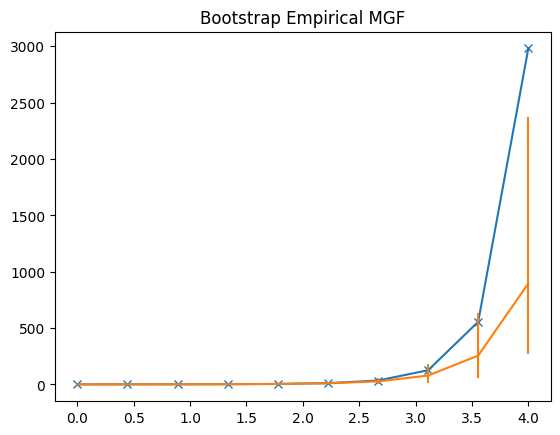

In [252]:
plt.plot(ts, Mts, '-x')
plt.errorbar(ts, means, yerr=CIs.T)
plt.title('Bootstrap Empirical MGF')

Text(0.5, 1.0, 'Bootstrap Empirical MGF - zoom')

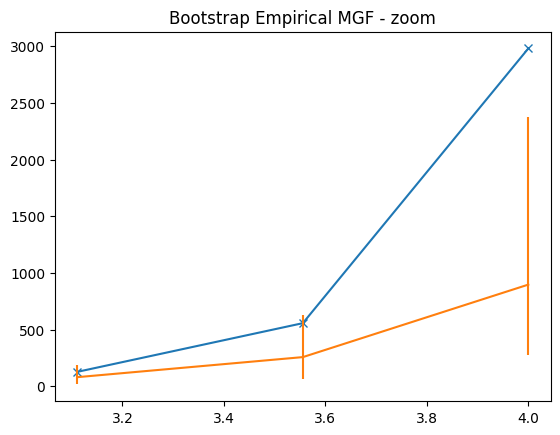

In [250]:
plt.plot(ts[-3:], Mts[-3:], '-x')
plt.errorbar(ts[-3:], means[-3:], yerr=CIs[-3:, :].T)
plt.title('Bootstrap Empirical MGF - zoom')

Yeah, like this is not even close at higher parameters.

I think that the reason for this is: for large values of the exponential, the distribution becomes very 'bottom heavy'. Any negative value contributes essentially a zero to the mean, while large positive values contribute an inordinately large amount. This means that the most important samples, the very large ones, we sample extremely rarely. Thus, we usually undershoot in our estimates of the mean because of our finite sample size. That is, the samples that overshoot do so massively, but become vanishingly rare.

In that sense, it's not really a bias. It's more like varaince that we only sample one part of.

#### Can we detect this by examining where the mean falls in the interval?

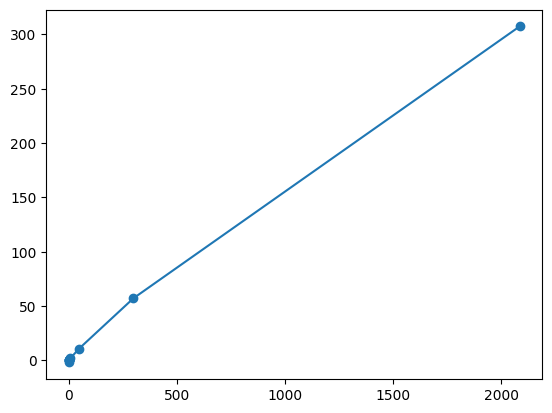

In [269]:
mean = np.array(means)

diff = Mts - mean
upper_vs_lower = (CIs - mean[:, None]).sum(axis=1)

plt.plot(diff, upper_vs_lower, '-o')

Yes, this looks like a fairly good way to detect such a thing.

### Using the bootstrap intervals to do bias correction?

In [275]:
diffs = (CIs - mean[:, None])

interval_ratio = diffs[:,1] / -diffs[:,0]

In [276]:
interval_ratio

array([-1.        ,  1.09468877,  1.05840991,  1.120734  ,  1.23253413,
        1.4362773 ,  1.497405  ,  1.71008678,  1.92726918,  2.12586604])

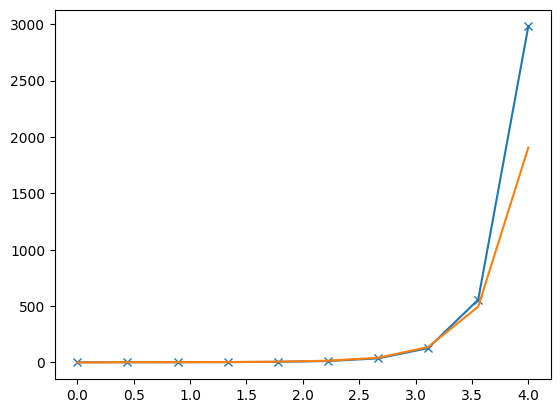

In [280]:
plt.plot(ts, Mts, '-x')
plt.plot(ts, means * interval_ratio)

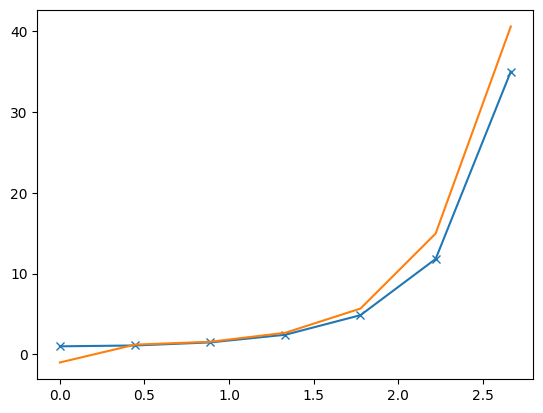

In [281]:
plt.plot(ts[:-3], Mts[:-3], '-x')
plt.plot(ts[:-3], means[:-3] * interval_ratio[:-3])

This gets us some of the way there: it improves the extreme estimates at the cost of over-shooting the lower ones. (Note that the first point at 0 is an artifact.)

## This is a well-known problem when estimating averages of heavy-tailed distributions.

I haven't (yet?) found a solution in the literature that uses the bootstrap intervals to correct estimates (like I tried above), but one commonly used approach seems to be a median of means.

In [333]:
data = np.random.randn(10000)
MGF_samples = np.exp(4*data)

target = np.exp(4**2/2)

splits = np.array(np.split(MGF_samples, 10000 // 10))
split_means = np.mean(splits, axis=1)

(-500.0, 20000.0)

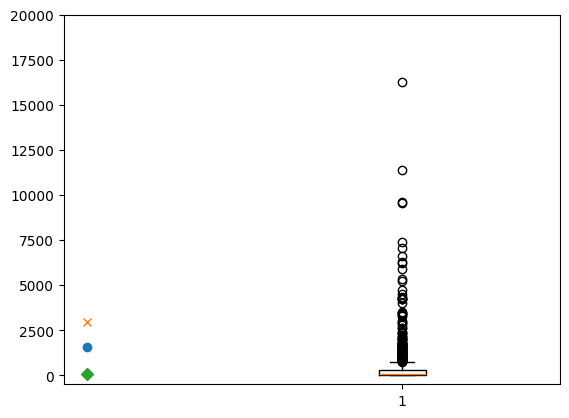

In [341]:
plt.boxplot(split_means)
plt.plot(MGF_samples.mean(), 'o')
plt.plot(target, 'x')
plt.plot(np.median(split_means), 'D')
plt.ylim([-500, 20000])

Ok, it is clear that the sub-sample means do surround the true mean, as well as the empirical means (note that I'm enforcing a max on the y axis so that the behavior is actually visible, individual samples go even higher).

However the basic median is not enough to recover the behavior. They use a geometric median? (geometric median == median in one dimension...)

This seems promising, but a little backward. We want an estimator that is _more_ sensitive to outliers in the mean, not less.



In [342]:
target

2980.9579870417283

In [343]:
MGF_samples.mean()

1562.113953496714

In [344]:
np.median(split_means)

65.39609856853268

In [345]:
np.mean(split_means)

1562.113953496714

In [578]:
splits

array([[3.52546956e-01, 3.48758590e-01, 8.96624203e+00, ...,
        2.36037981e+01, 4.20128605e+02, 9.61781926e+00],
       [1.39108861e+01, 1.13081846e-03, 2.21206376e+01, ...,
        3.02749739e+00, 1.74314355e-02, 6.37985859e-05],
       [7.58329854e+02, 6.23089255e-01, 1.09909587e-01, ...,
        1.22807601e-03, 2.45820430e+03, 8.00196599e+00],
       ...,
       [2.74042485e+00, 3.10510680e-01, 5.90780529e-01, ...,
        1.77394323e-01, 8.68432258e-01, 1.14313856e-02],
       [3.60082617e-02, 1.83347553e-01, 2.39395291e+03, ...,
        6.26020104e-01, 6.03613620e-01, 1.00903352e+02],
       [5.01870398e-03, 4.09179105e-02, 5.74874184e-01, ...,
        1.17286502e+03, 2.77410619e+00, 1.20938614e+00]])

## Trying out stabs at solutions


In [529]:
a = 2
data = a*np.random.randn(2000)

In [530]:
def make_CGF(ts, data):
    outs = []
    for t in ts:
        outs.append( np.exp(t*data).mean())
    return np.log(outs)

def true_CGF(ts):
    return a**2 * ts**2 / 2

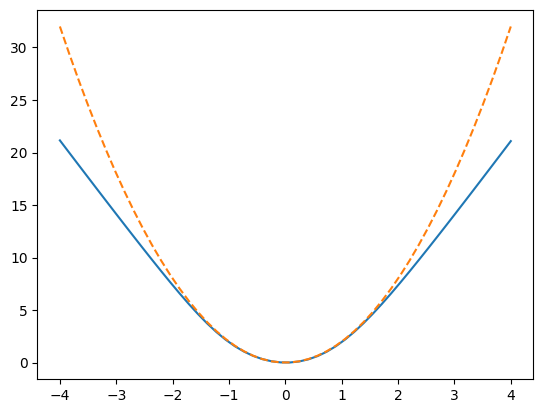

In [531]:
plt.plot(ts, make_CGF(ts, data))
plt.plot(ts, true_CGF(ts), '--')

### integration in the y domain

This reminds me of the change of variables that we needed in the problem with dad. Can we do an alternative empirical estimate by weighting by the width of the bins

Rather than evaluating at each sample, we bin the data, evaluate at the midpoints of the bins, and weight by the frequency of samples in each bin.

In [532]:
def data_domain(data, N=1000):
    """ regularly spaced intervals that cover all of the data """
    min = np.floor(data.min())
    max = np.ceil(data.max())

    return np.linspace(min, max, N)


In [533]:
def approximate_integral(data, func):
    dom = data_domain(data, 1000)
    counts, bins = np.histogram(data, dom)
    freqs = counts / data.shape[0]
    midpoints = (bins[:-1] + bins[1:])/2
    

    return (freqs * func(midpoints)).sum()


In [534]:
approximate_integral(data, lambda x: np.exp(x))

7.0197769875938185

In [535]:
ts = np.linspace(-4, 4)

pure_emp = []
density_emp = []

for t in ts:
    pure_emp.append( np.log(np.exp(t*data).mean()) )
    density_emp.append( np.log(approximate_integral(data, lambda x: np.exp(t*x))) )

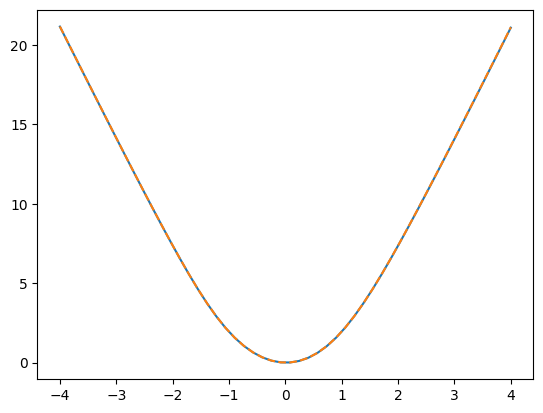

In [554]:
plt.plot(ts, pure_emp)
plt.plot(ts, density_emp, '--')

Now we do the same thing in the space of function outputs.

In [537]:
def approximate_integral_transform(data, func):
    dom = data_domain(data, 1000)
    counts, bins = np.histogram(data, dom)
    freqs = counts / data.shape[0]

    y_edges = func(bins)
    midpoints = (y_edges[:-1] + y_edges[1:])/2
    
    return (freqs * midpoints).sum()


In [538]:
ts = np.linspace(-4, 4)

pure_emp = []
density_emp_transform = []

for t in ts:
    pure_emp.append( np.log(np.exp(t*data).mean()) )
    density_emp_transform.append( np.log(approximate_integral_transform(data, lambda x: np.exp(t*x))) )

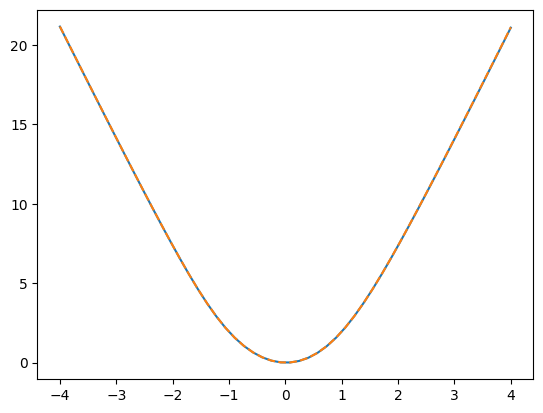

In [539]:
plt.plot(ts, pure_emp)
plt.plot(ts, density_emp_transform, '--')

Ok, this is actually identical to the other methods. Nice to see, but also annoying.

### What about using a kernel density estimator?

In [540]:
from scipy.stats import gaussian_kde

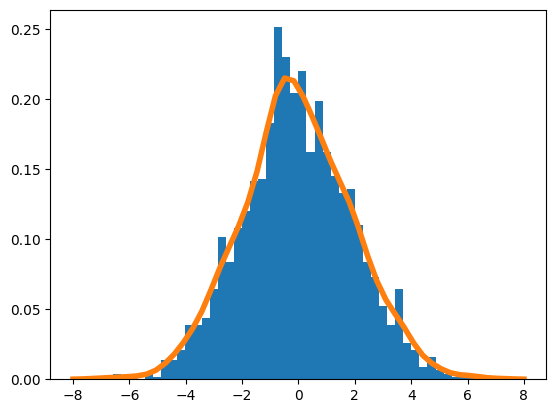

In [545]:
kde = gaussian_kde(data)

xs = np.linspace(-8,8)
plt.hist(data, bins=50, density=True)
plt.plot(xs, kde.pdf(xs), linewidth=4)

In [546]:
from scipy.integrate import quad

In [547]:
quad(lambda x: np.exp(4*x) * kde.pdf(x), -8, 8)

(3947952594.564083, 3.230903417104855)

In [571]:
def kde_integral(data, func):
    kde = gaussian_kde(data)
    return quad(lambda x: func(x) * kde.pdf(x), -10, 10)[0]

In [572]:
ts = np.linspace(-4, 4)

pure_emp = []
kde_est = []

for t in ts:
    pure_emp.append( np.log(np.exp(t*data).mean()) )
    kde_est.append( np.log(kde_integral(data, lambda x: np.exp(t*x))) )

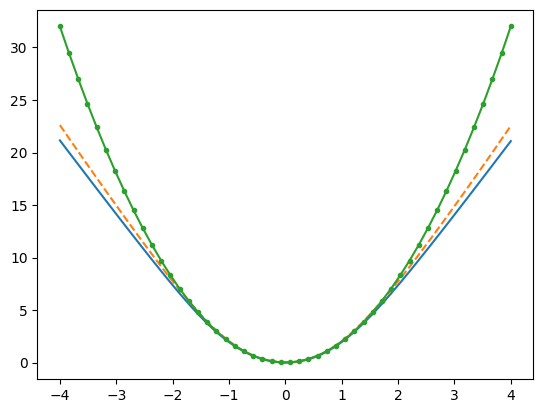

In [573]:
plt.plot(ts, pure_emp)
plt.plot(ts, kde_est, '--')
plt.plot(ts, true_CGF(ts), '.-')

Very slow. Slight improvement, but still significantly too low.

## Is this actually correct?

After all, by Cramer's theorem, the limiting slope reflects the CDF at extreme points.

When it becomes linear, the Legendre transform of on larger slopes goes to infinity. This is actually exactly what should happen

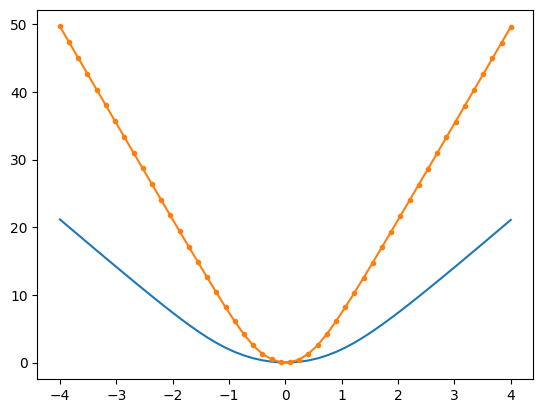

In [584]:
plt.plot(ts, make_CGF(ts, data))
plt.plot(ts, make_CGF(ts, 2*data), '.-')

The limiting slope does increase with wider variance.

## Comparison of rate function to CDF

In [590]:
from scipy.stats import ecdf

data_cdf = ecdf(data)

In [589]:
ecdf(data).cdf

EmpiricalDistributionFunction(quantiles=array([-7.15754815, -6.49691596, -6.39506417, ...,  6.18412027,
        6.29912818,  7.15191346]), probabilities=array([5.000e-04, 1.000e-03, 1.500e-03, ..., 9.990e-01, 9.995e-01,
       1.000e+00]))

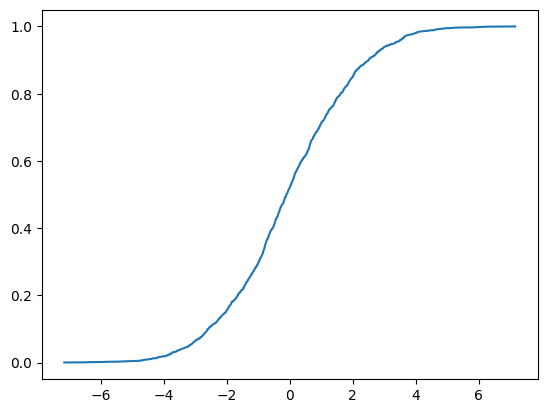

In [591]:
plt.plot(data_cdf.cdf.quantiles, data_cdf.cdf.probabilities)

## Using large deviations rate function to detect changes in the statistics

In [148]:
from scipy.stats import kstest, norm

In [162]:
data = 2*np.random.randn(20)
kstest(data, norm.cdf)

KstestResult(statistic=0.23088184854284732, pvalue=0.20248381286373895, statistic_location=-0.7751749250307026, statistic_sign=1)

In [175]:
data = 2*np.random.randn(2000)
blocks = np.split(data, 100)
block_mean = np.fromiter( map(np.mean, blocks), float)

kstest( block_mean, norm(0, 1./20**0.5).cdf )

KstestResult(statistic=0.22134197601537897, pvalue=8.765144341767133e-05, statistic_location=-0.21454666879725331, statistic_sign=1)

The real question that we want to ask is _how sensitive_ the mean ks test is relative to a test on the data itself.

Is is sensitive enough? Is it too sensitive? How do these properties change as we increase the number of points that we are averaging?